In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata as ad
from scipy.sparse import csr_matrix
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import math
import gc
import random
from sklearn.utils import shuffle

In [2]:
%matplotlib inline

##################
# Configure file #
##################
sc.settings.verbosity = 2
sc.settings.autoshow = False

##logging.basicConfig(filename="CLUESImmVar_processed.V4.1.log", level=logging.ERROR)
sc.settings.set_figure_params(dpi=100, dpi_save=300, format='png', frameon=False, transparent=True)

plt.rcParams["image.aspect"] = "equal"

# Read in the data, this could take a while

In [3]:
adata = sc.read('V6.3.flareAb.h5ad', cache=True)
print(adata)
figdir = "./figures."
sc.settings.figdir = "./figures."

Only considering the two last: ['.flareAb', '.h5ad'].
Only considering the two last: ['.flareAb', '.h5ad'].
AnnData object with n_obs × n_vars = 145158 × 1161 
    obs: 'SOURCE', 'TR_UNT', 'batch_cov', 'ind_cov', 'well', 'Female', 'pop_cov', 'Broad', 'CD38|CD38|j95-01|pAbO', 'CD95|FAS|j95-02|pAbO', 'CD28|CD28|j95-07|pAbO', 'CD27|CD27|j95-08|pAbO', 'CD197|CCR7|j95-09|pAbO', 'CD19|CD19|j95-10|pAbO', 'CD161|KLRB1|j95-11|pAbO', 'CD183|CXCR3|j95-12|pAbO', 'CD4|CD4|j95-14|pAbO', 'CD3|CD3E|j95-16|pAbO', 'CD196|CCR6|j95-17|pAbO', 'HLA-DR|CD74|j95-18|pAbO', 'CD45RO|PTPRC|j95-19|pAbO', 'CD14|CD14|j95-20|pAbO', 'CD194|CCR4|j95-21|pAbO', 'CD185|CXCR5|j95-22|pAbO', 'CD25|IL2RA|j95-24|pAbO', 'CD8|CD8A|j95-25|pAbO', 'CD127|IL7R|j95-27|pAbO', 'CD45RA|PTPRC|j95-28|pAbO', 'disease_cov', 'percent_mito', 'n_counts', 'n_genes', 'PF4', 'SDPR', 'GNG11', 'PPBP', 'PC3', 'PC16', 'louvain', 'leiden'
    uns: 'barcodes', 'diffmap_evals', 'genes', 'leiden', 'louvain', 'neighbors', 'pca', 'raw_counts', 'total_pbmcs

In [4]:
# Based on feature maps, we see near complete B cell depletion with two of three individuals in dataset. Rituximab treatment
# would result in an effect like this, therefore we can establish the treatment/untreated identity of each subject.
adata.obs['disease_cov'] = adata.obs['disease_cov'].astype('str')
# 904194200_904194200 #
adata.obs['disease_cov'][(adata.obs['disease_cov']=='Unknown (1 TR, 2 UNT)') & (adata.obs['ind_cov']=='904194200_904194200')] = 'UNT'
adata.obs['disease_cov'][(adata.obs['disease_cov']=='Unknown (2 TR, 1 UNT)') & (adata.obs['ind_cov']=='904194200_904194200')] = 'TR'

# 1586_1586 #
adata.obs['disease_cov'][(adata.obs['disease_cov']=='Unknown (1 TR, 2 UNT)') & (adata.obs['ind_cov']=='1586_1586')] = 'TR'
adata.obs['disease_cov'][(adata.obs['disease_cov']=='Unknown (2 TR, 1 UNT)') & (adata.obs['ind_cov']=='1586_1586')] = 'UNT'

# 1763_1763 # TR in Unknown (2 TR, 1 UNT)
adata.obs['disease_cov'][(adata.obs['disease_cov']=='Unknown (1 TR, 2 UNT)') & (adata.obs['ind_cov']=='1763_1763')] = 'UNT'
adata.obs['disease_cov'][(adata.obs['disease_cov']=='Unknown (2 TR, 1 UNT)') & (adata.obs['ind_cov']=='1763_1763')] = 'TR'
    

/netapp/home/richardkperez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/netapp/home/richardkperez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/netapp/home/richardkperez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/netapp/home/richardkperez/anaconda3/lib/python3.6

In [5]:
## since we have replicates, let's sort adata in a consistent way
adata_obs_sorted = adata.obs.sort_values(by=['disease_cov','ind_cov','batch_cov'], ascending=False);
adata = adata[adata_obs_sorted.index]

In [6]:
adata.obs['site'] = pd.Categorical(adata.obs.disease_cov, categories=['Broad','UCSF'])
adata.obs.site[adata.obs.batch_cov.str.contains("IMMVAR")] = "Broad"
adata.obs.site[~adata.obs.batch_cov.str.contains("IMMVAR")] = "UCSF"

adata.obs['disease_pop_site_cov'] = pd.Categorical(adata.obs.apply(lambda row: row['disease_cov'] + row['pop_cov'] + row['site'], axis=1),
                                             ordered=True)

# Sorting proportions by healthy versus treated versus untreated.
adata.obs['ind_cov_disease_cov'] = pd.Categorical(adata.obs.apply(lambda row: row['ind_cov']+ row['disease_cov'], axis=1),
                                             ordered=True)
adata.obs.to_csv('adata.obs.txt')

# Figure 6A: Projection and dropprint

... storing 'disease_cov' as categorical


saving figure to file ./figures./umap.disease_pop.png


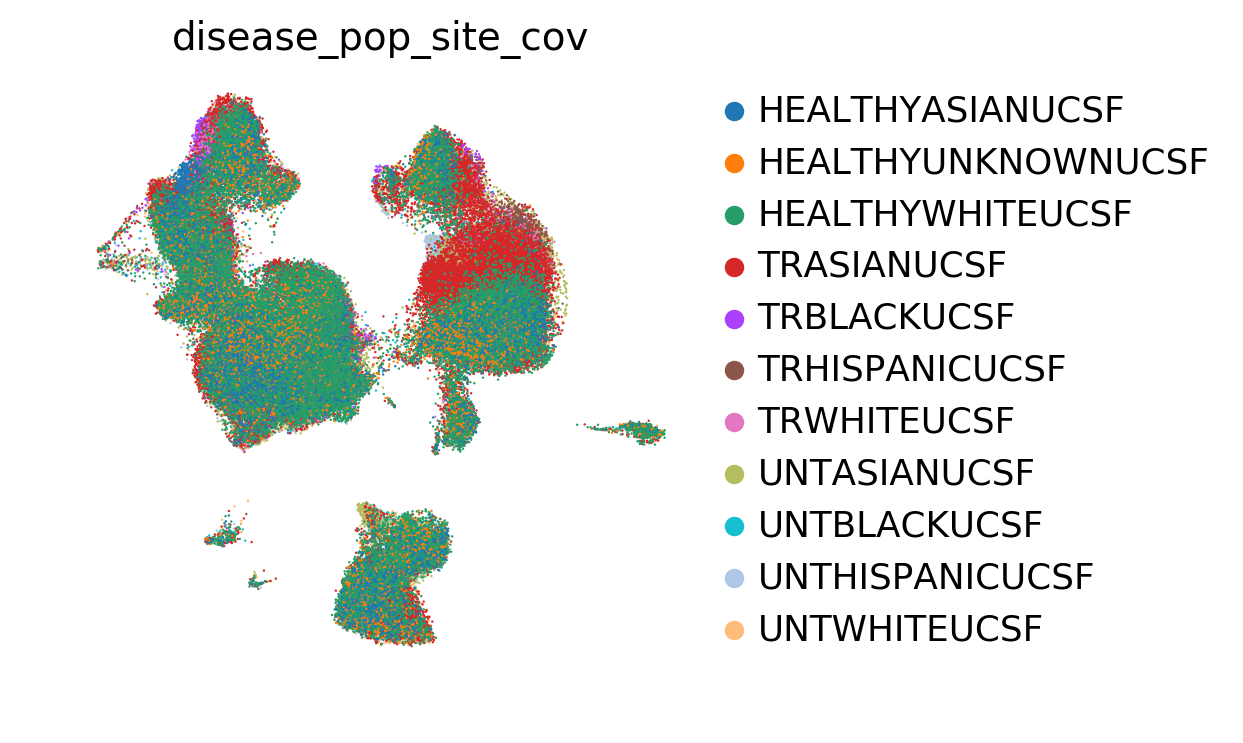

In [7]:
sc.pl.umap(adata, size=3, color="disease_pop_site_cov")
sc.pl.umap(adata, size=3, color="disease_pop_site_cov", edgecolor="none", save='.disease_pop.png', palette=sc.pl.palettes.vega_20_scanpy)

saving figure to file ./figures./umap.disease.png


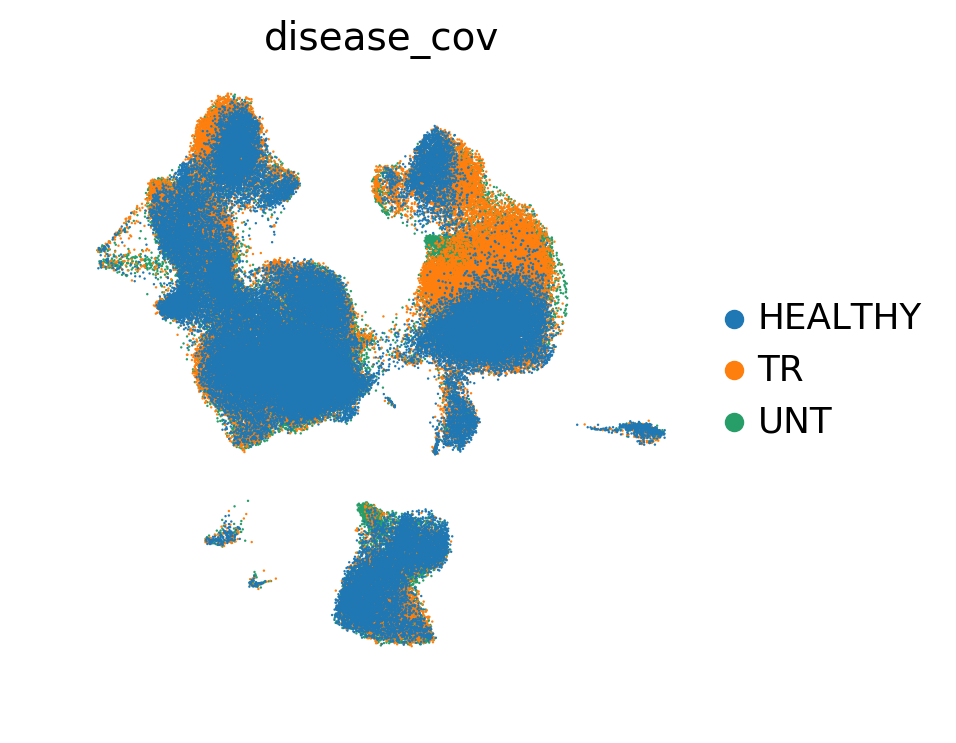

In [8]:
disease_umap = sc.pl.umap(adata, color='disease_cov', size=3, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy)
disease_umap = sc.pl.umap(adata, color='disease_cov', size=3, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy, save='.disease.png')

saving figure to file ./figures./umap.batch.png


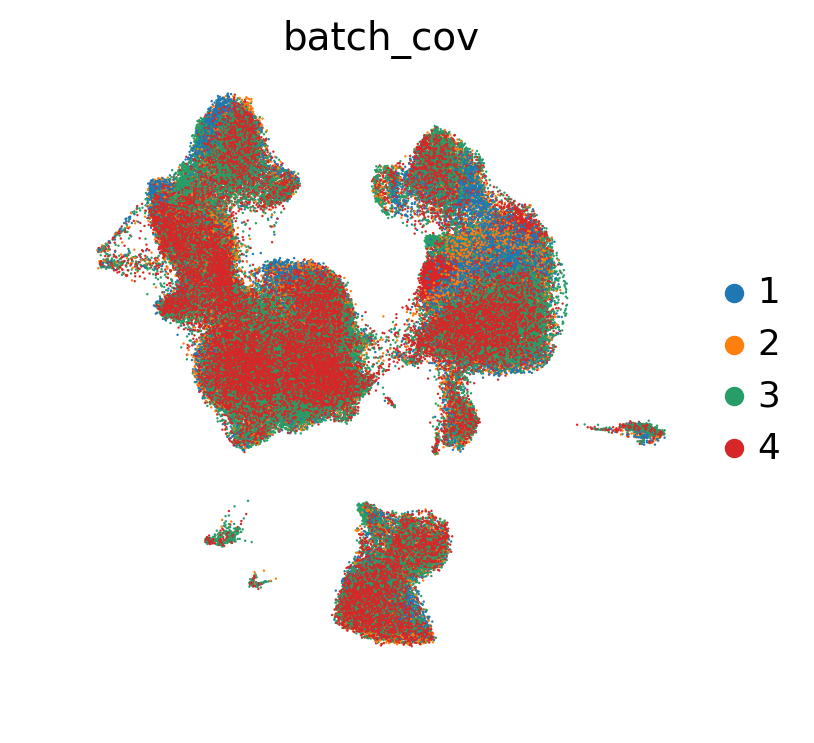

In [9]:
disease_umap = sc.pl.umap(adata, color='batch_cov', size=3, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy)
disease_umap = sc.pl.umap(adata, color='batch_cov', size=3, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy, save='.batch.png')

## Now, let's make a plot for each of the 16 people in batch 1 as a demo of variability

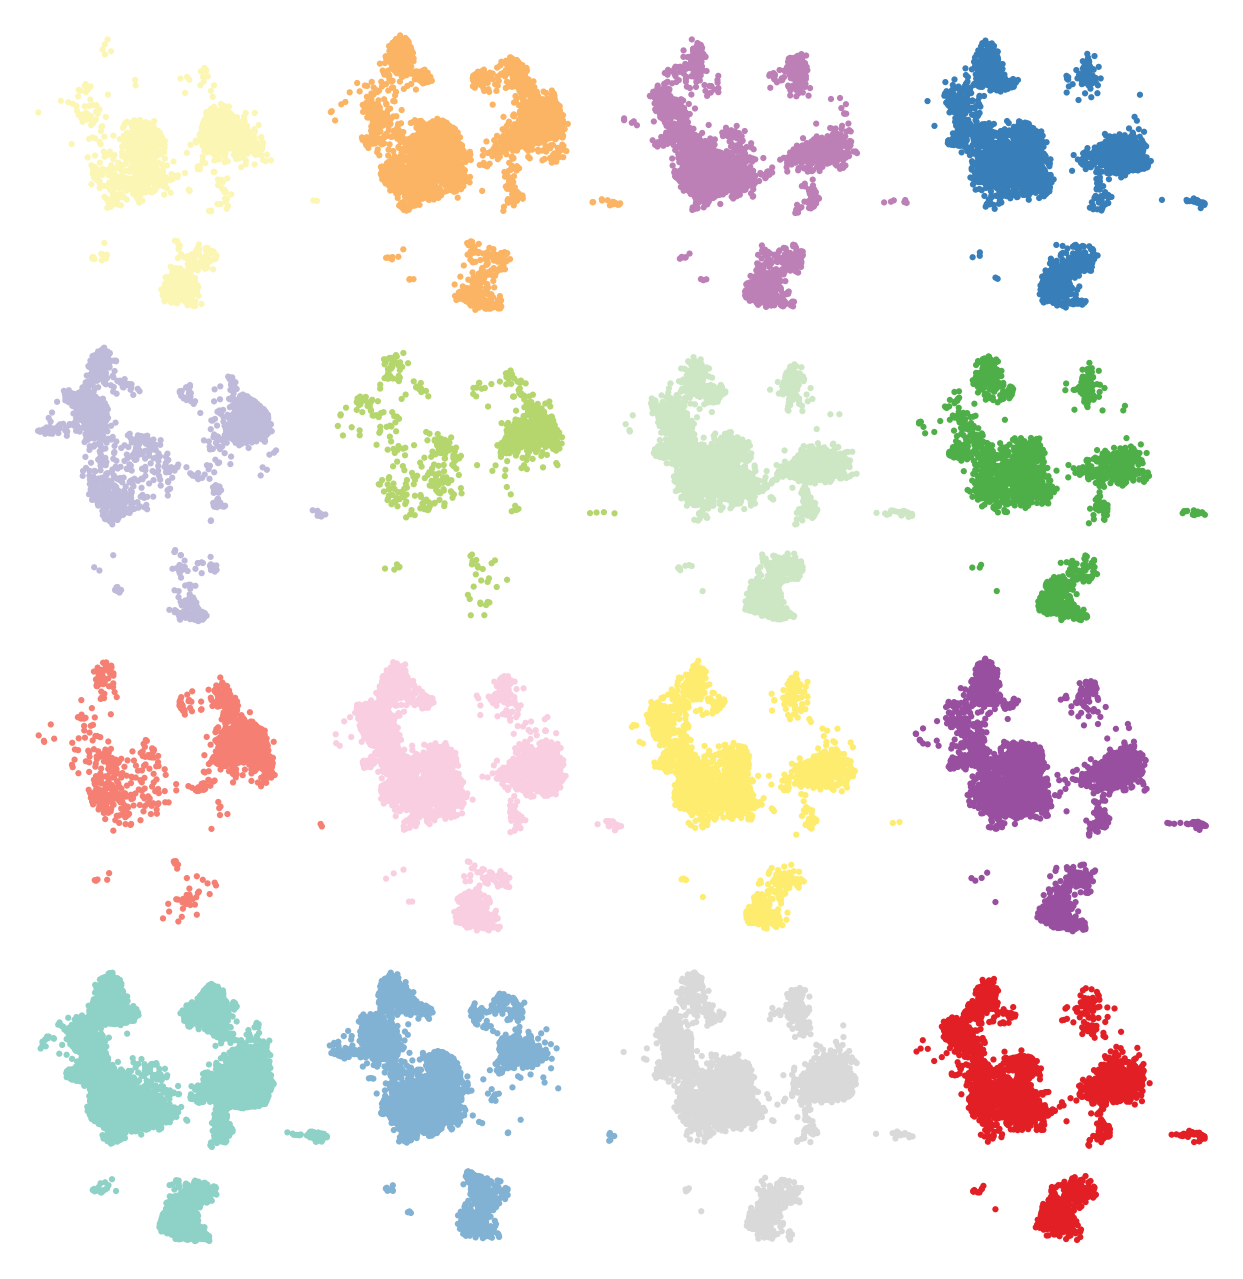

In [10]:
## let's plot 16 plots for the individuals.
colors = ["#8ED1C6","#FCF6B5", "#BEBAD9", "#F47F72", "#81B1D3", "#FBB463", "#B4D66C", "#F9CEE1", "#DAD9D9", "#BC80B7", "#CDE6C4", "#FEEC6E", "#E31F26", "#387EB9", "#4EAF49", "#984F9F"];
fig,ax = plt.subplots(nrows=4,ncols=4, figsize=(7,7),sharex=True, sharey=True)
fig.tight_layout()
plt.subplots_adjust(wspace=-0.1, hspace=0)

batch_name = adata.obs.batch_cov.unique()[0]
batch = adata.obs.ind_cov_disease_cov[adata.obs.batch_cov==batch_name].unique();
batch = np.sort(batch.categories.values)
for ind_i in list(range(batch.shape[0])):
    ind = batch[ind_i]
    col = colors[ind_i]
    sc.pl.umap(adata[adata.obs.ind_cov_disease_cov==ind,], color = "ind_cov_disease_cov", title=None, palette=[col,col], ax=ax[(ind_i-1)%4,math.floor(ind_i/4)], size=20, edgecolor="none")
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_xaxis().set_visible(False)
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_yaxis().set_visible(False)
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_legend().remove()
    ax[(ind_i-1)%4,math.floor(ind_i/4)].set_title("")
    ax[(ind_i-1)%4,math.floor(ind_i/4)].set_aspect("equal")

fig.savefig(figdir+'/'+batch_name+'.ind.png')

In [11]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes


KeyboardInterrupt: 

In [ ]:
MASTERCOLORS = sc.pl.palettes.default_64
MASTERCOLORS.remove("#FEFFE6")
sc.pl.umap(adata, color='leiden',size=3, edgecolor="none", palette=MASTERCOLORS)
sc.pl.umap(adata, color='leiden', size=3, edgecolor="none", save='.leiden.png', palette=MASTERCOLORS)

# Most expressed genes per leiden group

In [ ]:
pd.set_option('display.max_columns', None)
unique_leiden = np.unique(adata.obs['leiden'].values)
# Compile list of top genes
GeneRanks = pd.DataFrame()
for ii in range(len(unique_leiden)):
    GeneRanks[str('leiden_' + str(ii))] = adata.var_names[np.flipud(np.argsort(np.mean(adata.X[adata.obs['leiden'] == str(ii)], axis=0)))]
GeneRanks.to_csv('FLARE_top_expression.csv')
GeneRanks.head(20)

In [ ]:
def marker_gene_expression(anndata, marker_dict, gene_symbol_key=None, partition_key='louvain_r1'):
   """A function go get mean z-score expressions of marker genes
   #
   # Inputs:
   #    anndata         - An AnnData object containing the data set and a partition
   #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or
   #                      an anndata.var field with the key given by the gene_symbol_key input
   #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker
   #                      genes
   #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
   #                      'louvain_r1' """

   #Test inputs
   if partition_key not in anndata.obs.columns.values:
       print('KeyError: The partition key was not found in the passed AnnData object.')
       print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
       raise

   if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
       print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
       print('   Check that your cell type markers are given in a format that your anndata object knows!')
       raise


   if gene_symbol_key:
       gene_ids = anndata.var[gene_symbol_key]
   else:
       gene_ids = anndata.var_names

   clusters = anndata.obs[partition_key].cat.categories
   n_clust = len(clusters)
   marker_exp = pd.DataFrame(columns=clusters)
   marker_exp['cell_type'] = pd.Series({}, dtype='str')
   marker_names = []

   z_scores = sc.pp.scale(anndata, copy=True)

   i = 0
   for group in marker_dict:
       # Find the corresponding columns and get their mean expression in the cluster
       for gene in marker_dict[group]:
           ens_idx = np.in1d(gene_ids, gene) #Note there may be multiple mappings
           if np.sum(ens_idx) == 0:
               continue
           else:
               z_scores.obs[ens_idx[0]] = z_scores.X[:,ens_idx].mean(1) #works for both single and multiple mapping
               ens_idx = ens_idx[0]

           clust_marker_exp = z_scores.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
           clust_marker_exp.append(group)
           marker_exp.loc[i] = clust_marker_exp
           marker_names.append(gene)
           i+=1

   #Replace the rownames with informative gene symbols
   marker_exp.index = marker_names

   return(marker_exp)

marker_dictionary = pd.DataFrame({"all": adata.var_names})



In [ ]:
# Load cross-sectional lymph data
lymph = pd.read_csv('/ye/yelabstore3/Richard/PlottingScripts/ez_scanpy/lupus_paper/figure4.lymphoid.T/lymph_expr.ct_cov.csv')
lymph.rename(columns={'Unnamed: 0':'Gene'}, inplace=True)
lymph = lymph.set_index('Gene')
del lymph.index.name
# lymph data genes
lymphgenes = lymph.index.tolist()
# Intersection of genes for lymph
flaredata = adata[:, adata.var_names.isin(lymphgenes)]
marker_dictionary = pd.DataFrame({"all": flaredata.var_names})
flarelymph = marker_gene_expression(flaredata, marker_dictionary, partition_key="leiden")
lymphresult = pd.concat([lymph, flarelymph], axis=1, join='inner')

mono = pd.read_csv('/ye/yelabstore3/Richard/PlottingScripts/ez_scanpy/lupus_paper/figure3.myeloid/myeloid_expr.ct_cov.csv')
mono.rename(columns={'Unnamed: 0':'Gene'}, inplace=True)
mono = mono.set_index('Gene')
del mono.index.name
# lymph data genes
monogenes = mono.index.tolist()
# Intersection of genes for mono
flaredata = adata[:, adata.var_names.isin(monogenes)]
marker_dictionary = pd.DataFrame({"all": flaredata.var_names})
flaremono = marker_gene_expression(flaredata, marker_dictionary, partition_key="leiden")
monoresult = pd.concat([mono, flaremono], axis=1, join='inner')



In [ ]:
print('Lymphocyte')
lymphcorr = lymphresult.corr()
lymphcorr.to_csv('Lymphocyte_CrossX_Flare_Correlations.csv')
lymphcorr.style.background_gradient(cmap='coolwarm').set_precision(2)
import seaborn as sns; sns.set(color_codes=True); sns.set(font_scale=0.75)
g = sns.clustermap(lymphcorr, yticklabels=True, xticklabels=True)
g.savefig("Lymphocyte_CrossX_Flare_Correlations.png")

In [ ]:
print('Myeloid')
monocorr = monoresult.corr()
monocorr.to_csv('Myeloid_CrossX_Flare_Correlations.csv')
monocorr.style.background_gradient(cmap='coolwarm').set_precision(2)
import seaborn as sns; sns.set(color_codes=True); sns.set(font_scale=0.75)
g = sns.clustermap(monocorr, yticklabels=True, xticklabels=True)
g.savefig("Myeloid_CrossX_Flare_Correlations.png")

# Cell type correlations with cross-sectional data

In [ ]:
# Figure 1 populations
adata.obs['ct_cov'] = adata.obs['batch_cov'].astype("str")
# # ## do some manual cell type assignment
adata.obs['ct_cov'].loc[adata.obs.leiden == "0"] = "B" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "1"] = "T4" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "2"] = "NK" ## good                                                                                     
adata.obs['ct_cov'].loc[adata.obs.leiden == "3"] = "T8" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "4"] = "T8" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "5"] = "T4" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "6"] = "cM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "7"] = "T8" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "8"] = "ncM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "9"] = "cM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "10"] = "cM" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "11"] = "T4" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "12"] = "B" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "13"] = "cM" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "14"] = "cM" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "15"] = "T4" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "16"] = "cM" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "17"] = "T4" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "18"] = "T8" ## good                                                                              
adata.obs['ct_cov'].loc[adata.obs.leiden == "19"] = "T4" ## good                                                                               
adata.obs['ct_cov'].loc[adata.obs.leiden == "20"] = "cM" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "21"] = "T8" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "22"] = "cDC" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "23"] = "NK" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "24"] = "MK" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "25"] = "B" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "26"] = "ncM" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "27"] = "TProlif" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "28"] = "pDC" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "29"] = "T4" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "30"] = "RBC" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "31"] = "B" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "32"] = "T4" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "33"] = "cM" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "34"] = "B" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "35"] = "T8" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "36"] = "Progenitor" ##
adata.obs['ct_cov'] = adata.obs.ct_cov.astype('category')


# Major subpopulations figure6a and figure6b

In [ ]:
adata.uns['ct_cov_colors'] = MASTERCOLORS
celltype_umap = sc.pl.umap(adata, color='ct_cov', size=3, edgecolor="none", save='.figure6a.png', palette=MASTERCOLORS)
celltype_umap = sc.pl.umap(adata, color='ct_cov',size=3, edgecolor="none", palette=MASTERCOLORS)

In [ ]:
## Make proportion plots
adata_obs_small = adata.obs
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_cov','disease_cov','pop_cov', 'ind_cov'])['ct_cov'].count()
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")
# Add weights to WLS
ind_perc['counts'] = ind_count.values.tolist()
## filter samples that have < 100 cells
ind_perc = ind_perc[ind_perc.ind_cov_disease_cov.isin(ind_count_sums.ind_cov_disease_cov[ind_count_sums.counts > 100])]

cg_cov = pd.DataFrame( {    'ct_cov':['pDC', 'iM',   'compM', 'NKCD16-', 'NKCD16+', 'Batypical', 'DB',      'Progrenitor',  'Th',    'Bplasma', 'Bmem',  'Bnaive', 'cM',   'ncM',  'iM',  'T4naive', 'Macro', 'T4mem', 'T8mem', 'T8em cyto1','T4IFN', 'T8em cyto2', 'T8em cyto3', 'T8naive', 'Treg',  'NK',    'TProlif', 'Tc1q+', 'cDC', 'RBC'], 
                          'ct_group':['mono', 'mono', 'mono',  'lymph',   'lymph',   'lymph',     'Doublet', 'Progrenitor',  'lymph', 'lymph',   'lymph', 'lymph',  'mono', 'mono', 'mono','lymph',   'mono',  'lymph', 'lymph', 'lymph',     'lymph', 'lymph',      'lymph',      'lymph',   'lymph', 'lymph', 'lymph',   'lymph', 'mono','RBC']})

# Add cell type macrogroup as observation
adata.obs['ct_group'] = adata.obs['ct_cov'].tolist()
celltypes = np.unique(cg_cov['ct_cov'].tolist())
for ii in range(len(celltypes)):
    adata.obs['ct_group'][adata.obs['ct_cov']==cg_cov['ct_cov'][ii]] = cg_cov['ct_group'][ii]

ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov_disease_cov = ind_count_sums.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_perc = ind_perc.set_index('ct_cov').join(cg_cov.set_index('ct_cov'))
ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_cov = ind_perc.ct_cov.astype('category')
ind_perc.ct_cov = ind_perc.ct_cov.cat.reorder_categories(adata.obs.ct_cov.cat.categories.values)


ORDER = ['cM', 'ncM', 'cDC', 'pDC', 'T4', 'T8', 'NK', 'TProlif', 'B', 'MK', 'Progenitor', 'RBC']
perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='violin', col_order=ORDER, col='ct_cov', col_wrap=4, cut=0, dodge=False, aspect=0.75, sharex=False, sharey=False, palette=MASTERCOLORS)
for ct_i in list(range(len(ORDER))):
    ct = ORDER[ct_i]
    sns.stripplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0", size=10, ax=perc_plot.axes[ct_i], jitter=False)
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], color="0", scale=0.5, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    
perc_plot.savefig(figdir+"/violin.ct_cov_figure6b.png")

def highlight(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    # bonferroni correction
    sig = data < (0.05/len(data))
    return [attr if v else '' for v in sig]

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Treated WEIGHTED BY COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['HEALTHY', 'TR'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.counts[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="TR"] = 0
    disease.values[disease=="HEALTHY"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Untreated WEIGHTED BY COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['HEALTHY', 'UNT'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.counts[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="UNT"] = 0
    disease.values[disease=="HEALTHY"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)


# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Untreated WEIGHTED BY COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['TR', 'UNT'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.counts[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="UNT"] = 0
    disease.values[disease=="TR"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. SLE WEIGHTED BY COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['HEALTHY', 'TR', 'UNT'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.counts[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease!="HEALTHY"] = 0
    disease.values[disease=="HEALTHY"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Higher resolution subpopulation labeling

In [7]:
adata.obs['ct_cov'] = adata.obs['batch_cov'].astype("str")
# # ## do some manual cell type assignment
adata.obs['ct_cov'].loc[adata.obs.leiden == "0"] = "Bnaive" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "1"] = "T4mem" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "2"] = "NKCD16+" ## good                                                                                     
adata.obs['ct_cov'].loc[adata.obs.leiden == "3"] = "T8naive" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "4"] = "T8em cyto1" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "5"] = "T4naive" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "6"] = "cM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "7"] = "T8em cyto1" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "8"] = "ncM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "9"] = "iM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "10"] = "cM" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "11"] = "T4naive" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "12"] = "Bmem" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "13"] = "cM" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "14"] = "Macro" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "15"] = "T4naive" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "16"] = "cM" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "17"] = "T4naive" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "18"] = "T8em cyto2" ## good                                                                              
adata.obs['ct_cov'].loc[adata.obs.leiden == "19"] = "Treg" ## good                                                                               
adata.obs['ct_cov'].loc[adata.obs.leiden == "20"] = "cM" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "21"] = "T8em cyto3" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "22"] = "cDC" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "23"] = "NKCD16-" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "24"] = "MK" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "25"] = "Batypical" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "26"] = "compM" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "27"] = "TProlif" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "28"] = "pDC" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "29"] = "T4naive" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "30"] = "RBC" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "31"] = "Bnaive" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "32"] = "Tc1q+" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "33"] = "cM" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "34"] = "Bplasma" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "35"] = "T8naive" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "36"] = "Progenitor" ##
adata.obs['ct_cov'] = adata.obs.ct_cov.astype('category')


/netapp/home/richardkperez/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
adata.uns['ct_cov_colors'] = MASTERCOLORS
celltype_umap = sc.pl.umap(adata, color='ct_cov', size=3, edgecolor="none", save='.figure6c.png', palette=MASTERCOLORS)
celltype_umap = sc.pl.umap(adata, color='ct_cov',size=3, edgecolor="none", palette=MASTERCOLORS)

# Map colors onto cell type labels

In [ ]:
colormapping = dict()
unique_ct = adata.obs.ct_cov.cat.categories.tolist()
for ii in range(len(unique_ct)):
    colormapping[unique_ct[ii]] = adata.uns['ct_cov_colors'][ii]

In [ ]:
## platelet effect
sc.pl.umap(adata, color=["PF4", "SDPR", "GNG11", "PPBP"], size=3, save='.platelet.png')

In [ ]:
## cycling
sc.pl.umap(adata, color=["KIAA0101","STMN1","TK1","MKI67"], size=3, save='.cycling.png')

In [ ]:
## MACROPHAGES
sc.pl.umap(adata, color=['CD163', 'HLA-DRB1', 'C1QA'], size=3, save=".MACRO.png")

In [ ]:
sc.pl.umap(adata, color=['XCL2', 'HBA1', 'SBF2'], size=3, show=True)

In [ ]:
## CD4, CD8 and NK axis
sc.pl.umap(adata, color=["CD3D","CD8A","CD4","NCAM1", "FCGR3A", 'NKG7', 'IFNG', 'GZMB', 'PRF1'],size=3)
sc.pl.umap(adata, color=["CD3D","CD8A","CD4","NCAM1", "FCGR3A", 'NKG7', 'IFNG', 'GZMB', 'PRF1'],size=3, save=".TNK.png")
# Two NK sub populations: CD56high/lowCD16high/low, CD56lowCD16high
# https://www.frontiersin.org/files/Articles/162361/fimmu-06-00567-HTML/image_m/fimmu-06-00567-g001.jpg
bdata = adata[adata.obs['ct_cov'].isin(['NKCD16+', 'NKCD16-'])]
sc.pl.violin(bdata, groupby='leiden', keys=["NCAM1", "FCGR3A"])

In [ ]:
## Memory vs. helper vs. naive
sc.pl.umap(adata, color=["CCR7","IL7R","S100A4","CD58", 'FAS', 'IL2RA'],size=3, save=".TMemThTNaive.png")

In [ ]:
## treg
sc.pl.umap(adata, color=["FOXP3","TNFRSF4","ENTPD1","CCR10"],size=3, save=".TREG.png")

In [ ]:
## y chromosome gender effect
sc.pl.umap(adata, color=["DDX3Y", "RPS4Y1", "FHIT","TRAT1"], size =3, save=".Y.png")

In [ ]:
## b cells, plasmablasts and pdcs
sc.pl.umap(adata, color=["MZB1", "IGJ", "CD79A", 'CD27', 'FCRL5', 'IL6', 'FCRLA', 'FCRL3'],size=3, save=".B.png")

# Statistics

In [ ]:
## Make proportion plots
adata_obs_small = adata.obs
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_cov','disease_cov','pop_cov', 'ind_cov'])['ct_cov'].count()
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")
# Add weights to WLS
ind_perc['counts'] = ind_count.values.tolist()
## filter samples that have < 100 cells
ind_perc = ind_perc[ind_perc.ind_cov_disease_cov.isin(ind_count_sums.ind_cov_disease_cov[ind_count_sums.counts > 100])]

cg_cov = pd.DataFrame( {    'ct_cov':['pDC', 'iM',   'compM', 'NKCD16-', 'NKCD16+', 'Batypical', 'DB',      'Progrenitor',  'Th',    'Bplasma', 'Bmem',  'Bnaive', 'cM',   'ncM',  'iM',  'T4naive', 'Macro', 'T4mem', 'T8mem', 'T8em cyto1','T4IFN', 'T8em cyto2', 'T8em cyto3', 'T8naive', 'Treg',  'NK',    'TProlif', 'Tc1q+', 'cDC', 'RBC'], 
                          'ct_group':['mono', 'mono', 'mono',  'lymph',   'lymph',   'lymph',     'Doublet', 'Progrenitor',  'lymph', 'lymph',   'lymph', 'lymph',  'mono', 'mono', 'mono','lymph',   'mono',  'lymph', 'lymph', 'lymph',     'lymph', 'lymph',      'lymph',      'lymph',   'lymph', 'lymph', 'lymph',   'lymph', 'mono','RBC']})

# Add cell type macrogroup as observation
adata.obs['ct_group'] = adata.obs['ct_cov'].tolist()
celltypes = np.unique(cg_cov['ct_cov'].tolist())
for ii in range(len(celltypes)):
    adata.obs['ct_group'][adata.obs['ct_cov']==cg_cov['ct_cov'][ii]] = cg_cov['ct_group'][ii]

ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov_disease_cov = ind_count_sums.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_perc = ind_perc.set_index('ct_cov').join(cg_cov.set_index('ct_cov'))
ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_cov = ind_perc.ct_cov.astype('category')
ind_perc.ct_cov = ind_perc.ct_cov.cat.reorder_categories(adata.obs.ct_cov.cat.categories.values)

def highlight(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    # bonferroni correction
    sig = data < (0.05/len(data))
    return [attr if v else '' for v in sig]

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Treated WEIGHTED BY COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['HEALTHY', 'TR'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.counts[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="TR"] = 0
    disease.values[disease=="HEALTHY"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Untreated WEIGHTED BY COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['HEALTHY', 'UNT'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.counts[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="UNT"] = 0
    disease.values[disease=="HEALTHY"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)


# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Untreated WEIGHTED BY COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['TR', 'UNT'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.counts[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="UNT"] = 0
    disease.values[disease=="TR"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. SLE WEIGHTED BY COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['HEALTHY', 'TR', 'UNT'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.counts[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease!="HEALTHY"] = 0
    disease.values[disease=="HEALTHY"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)


# Lymphocytes

In [ ]:
ORDER = ['T4naive', 'T4mem', 'Treg', 'T8naive', 'T8em cyto1', 'T8em cyto2', 'T8em cyto3', 'TProlif', 'Tc1q+', 'NKCD16+', 'NKCD16-', 'Bnaive', 'Bmem', 'Batypical', 'Bplasma',
        ]
perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='violin', col_order=ORDER, col='ct_cov', col_wrap=4, cut=0, dodge=False, aspect=0.75, sharex=False, sharey=False, palette=MASTERCOLORS)
for ct_i in list(range(len(ORDER))):
    ct = ORDER[ct_i]
    sns.stripplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0", size=10, ax=perc_plot.axes[ct_i], jitter=False)
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], color="0", scale=0.5, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    
perc_plot.savefig(figdir+"/violin.figure6dlymphct.png")


# Monocytes

In [ ]:
ORDER = ['cM', 'iM','ncM', 'compM', 'Macro', 'cDC', 'pDC'
        ]
perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='violin', col_order=ORDER, col='ct_cov', col_wrap=4, cut=0, dodge=False, aspect=0.75, sharex=False, sharey=False, palette=MASTERCOLORS)
for ct_i in list(range(len(ORDER))):
    ct = ORDER[ct_i]
    sns.stripplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0", size=10, ax=perc_plot.axes[ct_i], jitter=False)
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], color="0", scale=0.5, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    
perc_plot.savefig(figdir+"/violin.figure6dmonoct.png")

# Other Cell Types

In [ ]:
ORDER = ['MK', 'Progenitor', 'RBC', 'DB'
        ]
perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='violin', col_order=ORDER, col='ct_cov', col_wrap=7, cut=0, dodge=False, aspect=0.75, sharex=False, sharey=False, palette=MASTERCOLORS)
for ct_i in list(range(len(ORDER))):
    ct = ORDER[ct_i]
    sns.stripplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0", size=10, ax=perc_plot.axes[ct_i], jitter=False)
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], color="0", scale=0.5, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    
perc_plot.savefig(figdir+"/violin.figure6dotherct.png")

In [ ]:
# histogram of # cells/individual
display(ind_count_sums)
sns.distplot(ind_count_sums.counts)


In [ ]:
'''
ind_perc['disease_pop_cov'] = pd.Categorical(ind_perc.apply(lambda row: row['disease_cov'] + row['pop_cov'], axis=1),
                                             ordered=True)
perc_plot = sns.catplot(x='disease_pop_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='violin', col='ct_cov', aspect=1, height=4, 
                        dodge=False, sharex=False, sharey=False, col_wrap=5, cut=0, palette=MASTERCOLORS)
perc_plot.set_xticklabels(rotation=90)
perc_plot.fig.subplots_adjust(wspace=0.5)

for ct_i in list(range(len(ind_perc.ct_cov.cat.categories))) :
    ct = ind_perc.ct_cov.cat.categories[ct_i]
    try:
        sns.pointplot(x="disease_pop_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], color="0", scale=0.5, ax=perc_plot.axes[ct_i])
    except:
        continue
    sns.swarmplot(x="disease_pop_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0", size=7, ax=perc_plot.axes[ct_i])
    #sns.swarmplot(x="disease_pop_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0", size=5, ax=perc_plot.axes[ct_i])
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()

perc_plot.savefig(figdir+"/violin.ct_cov_pop.png")
'''

# Lymphocyte and Monocyte proportions

In [ ]:
## Make proportion plots
adata_obs_small = adata.obs
## no batch_cov so that we aggregate the count for the two healthy controls
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_group','disease_cov', 'ind_cov'])['ct_group'].count()
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")
## filter samples that have < 100 cells
ind_perc = ind_perc[ind_perc.ind_cov_disease_cov.isin(ind_count_sums.ind_cov_disease_cov[ind_count_sums.counts > 100])]

ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov_disease_cov = ind_count_sums.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_perc = ind_perc.set_index('ct_group')
ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_group = ind_perc.ct_group.astype('category')
# Reorder categories for plotting
ORDER = ['lymph', 'mono', 'MK', 'Progenitor', 'RBC', 'Doublet']
perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_group', col_order=ORDER, data=ind_perc, kind='violin', col='ct_group', cut=0, dodge=False, aspect=0.75, sharex=False, sharey=False)

for ct_i in list(range(len(ORDER))) :
    ct = ORDER[ct_i]
    sns.stripplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_group == ct], color="0", size=10, ax=perc_plot.axes[0, ct_i], jitter=False)
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_group == ct], color="0", scale=0.5, ax=perc_plot.axes[0,ct_i])
    except:
        continue
    perc_plot.axes[0, ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[0, ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[0, ct_i].get_legend().remove()
    
perc_plot.savefig(figdir+"/violin.ct_group.png")
sc.pl.umap(adata, color='ct_group', show=True, size=3, save='.ct_group', edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy)

# Protein analysis

In [8]:
pdata = adata.copy()
print(pdata)

AnnData object with n_obs × n_vars = 145158 × 1161 
    obs: 'SOURCE', 'TR_UNT', 'batch_cov', 'ind_cov', 'well', 'Female', 'pop_cov', 'Broad', 'CD38|CD38|j95-01|pAbO', 'CD95|FAS|j95-02|pAbO', 'CD28|CD28|j95-07|pAbO', 'CD27|CD27|j95-08|pAbO', 'CD197|CCR7|j95-09|pAbO', 'CD19|CD19|j95-10|pAbO', 'CD161|KLRB1|j95-11|pAbO', 'CD183|CXCR3|j95-12|pAbO', 'CD4|CD4|j95-14|pAbO', 'CD3|CD3E|j95-16|pAbO', 'CD196|CCR6|j95-17|pAbO', 'HLA-DR|CD74|j95-18|pAbO', 'CD45RO|PTPRC|j95-19|pAbO', 'CD14|CD14|j95-20|pAbO', 'CD194|CCR4|j95-21|pAbO', 'CD185|CXCR5|j95-22|pAbO', 'CD25|IL2RA|j95-24|pAbO', 'CD8|CD8A|j95-25|pAbO', 'CD127|IL7R|j95-27|pAbO', 'CD45RA|PTPRC|j95-28|pAbO', 'disease_cov', 'percent_mito', 'n_counts', 'n_genes', 'PF4', 'SDPR', 'GNG11', 'PPBP', 'PC3', 'PC16', 'louvain', 'leiden', 'site', 'disease_pop_site_cov', 'ind_cov_disease_cov', 'ct_cov'
    uns: 'barcodes', 'diffmap_evals', 'genes', 'leiden', 'louvain', 'neighbors', 'pca', 'raw_counts', 'total_pbmcs'
    obsm: 'X_pca', 'X_diffmap', 'X_umap'


In [ ]:
import anndata as ad
import combat2
import combat
import patsy
# Find antibodies
ab_names = [ab for ab in pdata.obs_keys() if 'pAbO' in ab]
print(ab_names)
obs = pd.DataFrame()
obs['disease_cov'] = pdata.obs['disease_cov']
obs['batch_cov'] = pdata.obs['batch_cov']
obs['ct_cov_rna'] = pdata.obs['ct_cov']
var = pd.DataFrame(index=ab_names)
pdatapseudo = ad.AnnData(pdata.obs[ab_names].values, obs=obs, var=var, dtype='int32')
print(pdatapseudo)
#sc.pp.subsample(pdatapseudo, fraction=0.05)
#print(pdatapseudo)
pdatapseudo.obs['n_counts'] = np.ravel(pdatapseudo.X.sum(axis=1))
sc.pp.regress_out(pdatapseudo, ['batch_cov'])
logging.info('Scaling expression data')
sc.pp.scale(adata, max_value=10)
'''
## combat adjustment                                                                                                                                                                                                           
logging.info('Running combat')
mod = patsy.dmatrix("~ disease_cov", adata.obs, return_type="dataframe")
mod = mod.reset_index(drop=True)
batch = adata.obs['batch_cov']
batch = batch.reset_index(drop=True)
adata.X = combat.combat(adata.X.transpose(), batch=batch, model=mod).transpose();
'''
#######################
# Louvain and friends #
#######################
# Set parameters
intialization = 1
n_components = 5
resolution = 1
# Run louvain clustering on theoretical future gene expression per cell
logging.info('Estimating louvain cluster identities for gene expression values.')
sc.pp.pca(pdatapseudo ,random_state=intialization, svd_solver='arpack')
logging.info('PCA complete.')
sc.pp.neighbors(pdatapseudo, n_pcs=5, use_rep='X_pca', random_state=intialization)
#sc.pp.neighbors(pdatapseudo, random_state=intialization)
logging.info('KNN complete.')
sc.tl.leiden(pdatapseudo, random_state=intialization, resolution=resolution)
logging.info('Leiden complete.')
sc.tl.umap(pdatapseudo, random_state=intialization)
logging.info('UMAP complete.')
logging.info('Making .obs into categories')
adata.strings_to_categoricals()
logging.info('Basic analysis complete.')

... storing 'disease_cov' as categorical


['CD38|CD38|j95-01|pAbO', 'CD95|FAS|j95-02|pAbO', 'CD28|CD28|j95-07|pAbO', 'CD27|CD27|j95-08|pAbO', 'CD197|CCR7|j95-09|pAbO', 'CD19|CD19|j95-10|pAbO', 'CD161|KLRB1|j95-11|pAbO', 'CD183|CXCR3|j95-12|pAbO', 'CD4|CD4|j95-14|pAbO', 'CD3|CD3E|j95-16|pAbO', 'CD196|CCR6|j95-17|pAbO', 'HLA-DR|CD74|j95-18|pAbO', 'CD45RO|PTPRC|j95-19|pAbO', 'CD14|CD14|j95-20|pAbO', 'CD194|CCR4|j95-21|pAbO', 'CD185|CXCR5|j95-22|pAbO', 'CD25|IL2RA|j95-24|pAbO', 'CD8|CD8A|j95-25|pAbO', 'CD127|IL7R|j95-27|pAbO', 'CD45RA|PTPRC|j95-28|pAbO']
AnnData object with n_obs × n_vars = 145158 × 20 
    obs: 'disease_cov', 'batch_cov', 'ct_cov_rna'
regressing out ['batch_cov']
    finished (0:00:02.06)
computing neighbors
    finished (0:12:16.16)
running Leiden clustering
    finished (0:00:46.75)
computing UMAP


In [ ]:
sc.pl.umap(pdatapseudo, color='disease_cov', show=True, size=3, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy)
sc.pl.umap(pdatapseudo, color='batch_cov', show=True, size=3, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy)
sc.pl.umap(pdatapseudo, color='leiden', show=True, size=3, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy)
sc.pl.umap(pdatapseudo, color='ct_cov_rna', show=True, size=3, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy)


# Individual with very low monocyte count

In [ ]:
adata_obs_small = adata_obs_small[adata_obs_small.ind_cov_disease_cov=='FLARE015UNT']
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_group','disease_cov', 'ind_cov'])['ct_group'].count()
ind_count

In [ ]:
'''
pairs = ['FLARE004', 'FLARE009', 'FLARE011', 'FLARE013', 'FLARE016']
for pair in pairs:
    bdata = adata[adata.obs['ind_cov']==pair]
    print(pair)
    sc.pl.umap(bdata, size=10, show=True, color='ind_cov_disease_cov', palette=sc.pl.palettes.vega_20_scanpy)
    plt.show()
    ## Make proportion plots
    adata_obs_small = bdata.obs

    ## no batch_cov so that we aggregate the count for the two healthy controls
    ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_group','disease_cov', 'ind_cov'])['ct_group'].count()
    ind_count_sums = ind_count.groupby(level=[0]).sum()
    ind_count_sums = ind_count_sums.reset_index(name="counts")
    ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
    ind_perc = ind_perc.reset_index(name="ct_perc")
    ind_perc['counts'] = ind_count.values.tolist()
    ## filter samples that have < 100 cells
    ind_perc = ind_perc[ind_perc.ind_cov_disease_cov.isin(ind_count_sums.ind_cov_disease_cov[ind_count_sums.counts > 100])]

    ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
    ind_count_sums.ind_cov_disease_cov = ind_count_sums.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
    ind_perc = ind_perc.set_index('ct_group')
    ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.astype("str")
    ind_perc.reset_index(inplace=True)
    ind_perc.ct_group = ind_perc.ct_group.astype('category')
    # Reorder categories for plotting
    ORDER = ['lymph', 'mono', 'MK', 'precursor', 'RBC', 'Doublet']
    display(ind_perc)
'''

In [ ]:
# Break out by batch and do proportions within batch
batch = ['1', '2', '3', '4']
## Make proportion plots
adata_obs_small0 = adata.obs
adata_obs_small0 = adata_obs_small0[adata_obs_small0.ind_cov_disease_cov == '1240TR']
# batch 1
adata_obs_small = adata_obs_small0[adata_obs_small0.batch_cov == '1']
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_cov'])['ct_cov'].count()
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc1")
ind_perc['counts1'] = ind_count.values.tolist()

ind_perc_batch1 = ind_perc

# batch 2
adata_obs_small = adata_obs_small0[adata_obs_small0.batch_cov == '2']
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_cov'])['ct_cov'].count()
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc2")
ind_perc['counts2'] = ind_count.values.tolist()

ind_perc_batch2 = ind_perc

# batch 3
adata_obs_small = adata_obs_small0[adata_obs_small0.batch_cov == '3']
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_cov'])['ct_cov'].count()
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc3")
ind_perc['counts3'] = ind_count.values.tolist()

ind_perc_batch3 = ind_perc

# batch 4
adata_obs_small = adata_obs_small0[adata_obs_small0.batch_cov == '4']
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_cov'])['ct_cov'].count()
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc4")
ind_perc['counts4'] = ind_count.values.tolist()

ind_perc_batch4 = ind_perc

print(ind_perc_batch1.ct_perc1.sum())
print(ind_perc_batch2.ct_perc2.sum())
print(ind_perc_batch3.ct_perc3.sum())
print(ind_perc_batch4.ct_perc4.sum())

ind_perc_batch1 = ind_perc_batch1.set_index('ct_cov')
ind_perc_batch2 = ind_perc_batch2.set_index('ct_cov')
ind_perc_batch3 = ind_perc_batch3.set_index('ct_cov')
ind_perc_batch4 = ind_perc_batch4.set_index('ct_cov')

ind_perc_batch1234 = pd.concat([ind_perc_batch1, ind_perc_batch2, ind_perc_batch3, ind_perc_batch4], axis=1, sort=False)

display(ind_perc_batch1234)
plt.figure()
ax = sns.scatterplot(x="ct_perc1", y="ct_perc2", data=ind_perc_batch1234)
ax.plot([0, 50], [0, 50], ls="--", c=".3")
plt.figure()
ax = sns.scatterplot(x="ct_perc3", y="ct_perc4", data=ind_perc_batch1234)
ax.plot([0, 50], [0, 50], ls="--", c=".3")
plt.figure()
ax = sns.scatterplot(x="ct_perc2", y="ct_perc3", data=ind_perc_batch1234)
ax.plot([0, 50], [0, 50], ls="--", c=".3")
plt.figure()
ax = sns.scatterplot(x="ct_perc2", y="ct_perc4", data=ind_perc_batch1234)
ax.plot([0, 50], [0, 50], ls="--", c=".3")
plt.figure()
ax = sns.scatterplot(x="ct_perc1", y="ct_perc4", data=ind_perc_batch1234)
ax.plot([0, 50], [0, 50], ls="--", c=".3")

# Feature plots for Untreated Treated pairs

In [ ]:
pairs = ['FLARE004', 'FLARE009', 'FLARE011', 'FLARE013', 'FLARE016', '904194200_904194200', '1586_1586', '1763_1763']
for pair in pairs:
    bdata = adata[adata.obs['ind_cov']==pair]
    print(pair)
    sc.pl.umap(bdata, size=10, show=True, color='disease_cov', save=str(pair + '.disease.png'), palette=sc.pl.palettes.vega_20_scanpy)
    plt.show()
    

# Feature plot antibody expression

In [ ]:
adata_obs_small = adata.obs;
keys = adata_obs_small.keys().tolist()
antibodykeys = [key for key in keys if 'pAbO' in key]
#sc.pl.umap(adata, color='leiden')
print('Ab keys')
print(antibodykeys)

for key in antibodykeys:
    '''
    if key == 'CD45RA|PTPRC|j95-28|pAbO':
        sc.pl.umap(adata, color=key,size=2, show=True, save=str(key + '.antibody.png'))
    if key == 'CD45RO|PTPRC|j95-19|pAbO':
        sc.pl.umap(adata, color=key,size=2, show=True, save=str(key + '.antibody.png'))
    if key == 'CD27|CD27|j95-08|pAbO':
        sc.pl.umap(adata, color=key,size=2, show=True, save=str(key + '.antibody.png'))
    if key == 'CD8|CD8A|j95-25|pAbO':
        sc.pl.umap(adata, color=key,size=2, show=True, save=str(key + '.antibody.png'))
    if key == 'CD4|CD4|j95-14|pAbO':
        sc.pl.umap(adata, color=key,size=2, show=True, save=str(key + '.antibody.png'))
    else:
    '''
    sc.pl.umap(adata, color=key,size=2, show=False, vmin=0, vmax=2, save=str(key + '.antibody.png'))
    

# Trajectory between Naive CD4 and Activated CD4

In [ ]:
celltypes = ['T4mem', 'T4naive']
bdata = adata[adata.obs['ct_cov'].isin(celltypes)]
sc.tl.rank_genes_groups(bdata, groupby='ct_cov')
sc.pl.rank_genes_groups(bdata, n_genes=25, sharey=False)
genes0= list(zip(*bdata.uns['rank_genes_groups']['names']))
genes = []
for ii in range(len(celltypes)):
    genes.append(list(genes0[ii]))
GENES = [j for i in genes for j in i]

In [ ]:
sns.set(font_scale=1.25)
sc.settings.set_figure_params(dpi_save=250, format='png', transparent=True)
color_map = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2',
    '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896',
    '#c5b0d5', '#c49c94', '#f7b6d2',
    '#dbdb8d', '#9edae5',
    '#ad494a', '#8c6d31']
n_bins = 20
# Keep only memory and naive CD4s
bdata = adata[adata.obs['ct_cov'].isin(celltypes)]
genes = bdata.var_names[bdata.var_names.isin(GENES)].tolist()
#adata = adata[:, genes].X
# Order cells
PC = np.asarray(sc.pp.pca(bdata[:, genes].X, n_comps=1, copy=True)).reshape(-1,)
bdata.obs['PC_pseudotime'] = list(PC)
print(bdata)
sc.pl.umap(bdata, color='disease_cov', palette=color_map, show=True)
sc.pl.umap(bdata, color='PC_pseudotime', palette=color_map, show=True, save='T_Naive2Memory_pseudotime.png')
vals = np.asarray(bdata.obs['PC_pseudotime'].values.tolist())
# For Healthy
ind_healthy = bdata.obs['ind_cov'][bdata.obs['disease_cov']=='HEALTHY'].tolist()
for ind in ind_healthy:
    if ind == ind_healthy[0]:
        # pseudotime values for healthy
        healthynum = np.histogram(np.asarray(bdata.obs['PC_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        healthynum = healthynum/np.sum(healthynum)
    else:
        # pseudotime values for healthy
        healthynum0 = np.histogram(np.asarray(bdata.obs['PC_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        healthynum0 = healthynum0/np.sum(healthynum0)
        healthynum = np.concatenate((healthynum, healthynum0),axis=1)
healthyall = np.asarray(bdata.obs['PC_pseudotime'][bdata.obs['ind_cov'].isin(ind_healthy)].values.tolist())

# For UNTREATED
ind_FLARE = bdata.obs['ind_cov'][bdata.obs['disease_cov'].isin(['UNT'])].tolist()
for ind in ind_FLARE:
    if ind == ind_FLARE[0]:
        # pseudotime values for healthy
        FLAREnum = np.histogram(np.asarray(bdata.obs['PC_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        FLAREnum = FLAREnum/np.sum(FLAREnum)
    else:
        # pseudotime values for healthy
        FLAREnum0 = np.histogram(np.asarray(bdata.obs['PC_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        FLAREnum0 = FLAREnum0/np.sum(FLAREnum0)
        FLAREnum = np.concatenate((FLAREnum, FLAREnum0),axis=1)
FLAREall = np.asarray(bdata.obs['PC_pseudotime'][bdata.obs['ind_cov'].isin(ind_FLARE)].values.tolist())
    
# For TREATED
ind_TREATED = bdata.obs['ind_cov'][bdata.obs['disease_cov'].isin(['TR'])].tolist()
for ind in ind_TREATED:
    if ind == ind_TREATED[0]:
        # pseudotime values for healthy
        TREATEDnum = np.histogram(np.asarray(bdata.obs['PC_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        TREATEDnum = TREATEDnum/np.sum(TREATEDnum)
    else:
        # pseudotime values for healthy
        TREATEDnum0 = np.histogram(np.asarray(bdata.obs['PC_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        TREATEDnum0 = TREATEDnum0/np.sum(TREATEDnum0)
        TREATEDnum = np.concatenate((TREATEDnum, TREATEDnum0),axis=1)
TREATEDall = np.asarray(bdata.obs['PC_pseudotime'][bdata.obs['ind_cov'].isin(ind_TREATED)].values.tolist())

fig, ax = plt.subplots()
FLAREstd = stats.sem(FLAREnum, axis=1)
FLAREnum = np.mean(FLAREnum, axis=1)
TREATEDstd = stats.sem(TREATEDnum, axis=1)
TREATEDnum = np.mean(TREATEDnum, axis=1)
healthynumstd = stats.sem(healthynum, axis=1)
healthynum = np.mean(healthynum, axis=1)
ind = np.arange(n_bins)
width = 0.25
# Box plots
#p1 = ax.bar(ind, FLAREnum, width, yerr= FLAREstd, color='r', bottom=0, edgecolor = "none", label='Untreated')
#p1 = ax.bar(ind+width, TREATEDnum, width, yerr=TREATEDstd, color='b', bottom=0, edgecolor = "none", label='Treated')
#p1 = ax.bar(ind+width*2, healthynum, width, yerr=healthynumstd, color='k', bottom=0, edgecolor = "none", label='Healthy')
# Kernal Density -does not look too good
p1 = sns.kdeplot(FLAREall, color='r', label='Untreated')
p1 = sns.kdeplot(TREATEDall, color='b', label='Treated')
p1 = sns.kdeplot(healthyall, color="k", label='Healthy')
ax.set_title(str(str('PC_Naive_Memory') + '.png'))
ax.legend()
ax = plt.gca()
ax.grid(False)
#ax.set_yscale('log')
plt.savefig(str(str('PC_Naive_Memory') + '.png'))
plt.show()

# DPT for Naive to Memory (Poor result!)

In [ ]:
sns.set(font_scale=1.25)
sc.settings.set_figure_params(dpi_save=250, format='png', transparent=True)
color_map = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2',
    '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896',
    '#c5b0d5', '#c49c94', '#f7b6d2',
    '#dbdb8d', '#9edae5',
    '#ad494a', '#8c6d31']
n_bins = 20
# Keep only memory and naive CD4s
bdata = adata[adata.obs['ct_cov'].isin(celltypes)]
bdata.uns['iroot'] = np.flatnonzero(adata.obs['ct_cov'] == celltypes[0])[0]
sc.tl.dpt(bdata)
sc.pl.umap(bdata, color='dpt_pseudotime', palette=color_map, show=True)

vals = np.asarray(bdata.obs['dpt_pseudotime'].values.tolist())
# For Healthy
ind_healthy = bdata.obs['ind_cov'][bdata.obs['disease_cov']=='HEALTHY'].tolist()
for ind in ind_healthy:
    if ind == ind_healthy[0]:
        # pseudotime values for healthy
        healthynum = np.histogram(np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        healthynum = healthynum/np.sum(healthynum)
    else:
        # pseudotime values for healthy
        healthynum0 = np.histogram(np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        healthynum0 = healthynum0/np.sum(healthynum0)
        healthynum = np.concatenate((healthynum, healthynum0),axis=1)
healthyall = np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov'].isin(ind_healthy)].values.tolist())

# For UNTREATED
ind_FLARE = bdata.obs['ind_cov'][bdata.obs['disease_cov'].isin(['UNT'])].tolist()
for ind in ind_FLARE:
    if ind == ind_FLARE[0]:
        # pseudotime values for healthy
        FLAREnum = np.histogram(np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        FLAREnum = FLAREnum/np.sum(FLAREnum)
    else:
        # pseudotime values for healthy
        FLAREnum0 = np.histogram(np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        FLAREnum0 = FLAREnum0/np.sum(FLAREnum0)
        FLAREnum = np.concatenate((FLAREnum, FLAREnum0),axis=1)
FLAREall = np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov'].isin(ind_FLARE)].values.tolist())
    
# For TREATED
ind_TREATED = bdata.obs['ind_cov'][bdata.obs['disease_cov'].isin(['TR'])].tolist()
for ind in ind_TREATED:
    if ind == ind_TREATED[0]:
        # pseudotime values for healthy
        TREATEDnum = np.histogram(np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        TREATEDnum = TREATEDnum/np.sum(TREATEDnum)
    else:
        # pseudotime values for healthy
        TREATEDnum0 = np.histogram(np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        TREATEDnum0 = TREATEDnum0/np.sum(TREATEDnum0)
        TREATEDnum = np.concatenate((TREATEDnum, TREATEDnum0),axis=1)
TREATEDall = np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov'].isin(ind_TREATED)].values.tolist())

fig, ax = plt.subplots()
FLAREstd = stats.sem(FLAREnum, axis=1)
FLAREnum = np.mean(FLAREnum, axis=1)
TREATEDstd = stats.sem(TREATEDnum, axis=1)
TREATEDnum = np.mean(TREATEDnum, axis=1)
healthynumstd = stats.sem(healthynum, axis=1)
healthynum = np.mean(healthynum, axis=1)
ind = np.arange(n_bins)
width = 0.25
# Box plots
#p1 = ax.bar(ind, FLAREnum, width, yerr= FLAREstd, color='r', bottom=0, edgecolor = "none", label='Untreated')
#p1 = ax.bar(ind+width, TREATEDnum, width, yerr=TREATEDstd, color='b', bottom=0, edgecolor = "none", label='Treated')
#p1 = ax.bar(ind+width*2, healthynum, width, yerr=healthynumstd, color='k', bottom=0, edgecolor = "none", label='Healthy')
# Kernal Density -does not look too good
p1 = sns.kdeplot(FLAREall, color='r', label='Untreated')
p1 = sns.kdeplot(TREATEDall, color='b', label='Treated')
p1 = sns.kdeplot(healthyall, color="k", label='Healthy')
ax.set_title(str(str('dpt_Naive_Memory') + '.png'))
ax.legend()
ax = plt.gca()
ax.grid(False)
#ax.set_yscale('log')
plt.savefig(str(str('dpt_Naive_Memory') + '.png'))
plt.show()

# 1D trajectory for cM to Macrophage 

## diffusion pseudotime

In [ ]:
celltypes = ['Macro', 'cM']
sns.set(font_scale=1.25)
sc.settings.set_figure_params(dpi_save=250, format='png', transparent=True)
color_map = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2',
    '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896',
    '#c5b0d5', '#c49c94', '#f7b6d2',
    '#dbdb8d', '#9edae5',
    '#ad494a', '#8c6d31']
n_bins = 20
# Keep only memory and naive CD4s
bdata = adata[adata.obs['ct_cov'].isin(celltypes)]
bdata.uns['iroot'] = np.flatnonzero(adata.obs['ct_cov'] == celltypes[0])[0]
sc.tl.dpt(bdata)
sc.pl.umap(bdata, color='dpt_pseudotime', palette=color_map, show=True)

vals = np.asarray(bdata.obs['dpt_pseudotime'].values.tolist())
# For Healthy
ind_healthy = bdata.obs['ind_cov'][bdata.obs['disease_cov']=='HEALTHY'].tolist()
for ind in ind_healthy:
    if ind == ind_healthy[0]:
        # pseudotime values for healthy
        healthynum = np.histogram(np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        healthynum = healthynum/np.sum(healthynum)
    else:
        # pseudotime values for healthy
        healthynum0 = np.histogram(np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        healthynum0 = healthynum0/np.sum(healthynum0)
        healthynum = np.concatenate((healthynum, healthynum0),axis=1)
healthyall = np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov'].isin(ind_healthy)].values.tolist())

# For UNTREATED
ind_FLARE = bdata.obs['ind_cov'][bdata.obs['disease_cov'].isin(['UNT'])].tolist()
for ind in ind_FLARE:
    if ind == ind_FLARE[0]:
        # pseudotime values for healthy
        FLAREnum = np.histogram(np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        FLAREnum = FLAREnum/np.sum(FLAREnum)
    else:
        # pseudotime values for healthy
        FLAREnum0 = np.histogram(np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        FLAREnum0 = FLAREnum0/np.sum(FLAREnum0)
        FLAREnum = np.concatenate((FLAREnum, FLAREnum0),axis=1)
FLAREall = np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov'].isin(ind_FLARE)].values.tolist())
    
# For TREATED
ind_TREATED = bdata.obs['ind_cov'][bdata.obs['disease_cov'].isin(['TR'])].tolist()
for ind in ind_TREATED:
    if ind == ind_TREATED[0]:
        # pseudotime values for healthy
        TREATEDnum = np.histogram(np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        TREATEDnum = TREATEDnum/np.sum(TREATEDnum)
    else:
        # pseudotime values for healthy
        TREATEDnum0 = np.histogram(np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov']==ind].values.tolist()), bins=n_bins, range=(np.min(vals),np.max(vals)))[0].reshape(-1,1)
        TREATEDnum0 = TREATEDnum0/np.sum(TREATEDnum0)
        TREATEDnum = np.concatenate((TREATEDnum, TREATEDnum0),axis=1)
TREATEDall = np.asarray(bdata.obs['dpt_pseudotime'][bdata.obs['ind_cov'].isin(ind_TREATED)].values.tolist())

fig, ax = plt.subplots()
FLAREstd = stats.sem(FLAREnum, axis=1)
FLAREnum = np.mean(FLAREnum, axis=1)
TREATEDstd = stats.sem(TREATEDnum, axis=1)
TREATEDnum = np.mean(TREATEDnum, axis=1)
healthynumstd = stats.sem(healthynum, axis=1)
healthynum = np.mean(healthynum, axis=1)
ind = np.arange(n_bins)
width = 0.25
# Box plots
#p1 = ax.bar(ind, FLAREnum, width, yerr= FLAREstd, color='r', bottom=0, edgecolor = "none", label='Untreated')
#p1 = ax.bar(ind+width, TREATEDnum, width, yerr=TREATEDstd, color='b', bottom=0, edgecolor = "none", label='Treated')
#p1 = ax.bar(ind+width*2, healthynum, width, yerr=healthynumstd, color='k', bottom=0, edgecolor = "none", label='Healthy')
# Kernal Density -does not look too good
p1 = sns.kdeplot(FLAREall, color='r', label='Untreated')
p1 = sns.kdeplot(TREATEDall, color='b', label='Treated')
p1 = sns.kdeplot(healthyall, color="k", label='Healthy')
ax.set_title(str(str('dpt_Naive_Memory') + '.png'))
ax.legend()
ax = plt.gca()
ax.grid(False)
#ax.set_yscale('log')
plt.savefig(str('dpt_cM_-->_Macro' + '.png'))
plt.show()

## First PC composed of 25 most differentially expressed genes between cM and Macro

In [ ]:
celltypes = ['cM', 'Macro']
bdata = adata[adata.obs['ct_cov'].isin(celltypes)]
sc.tl.rank_genes_groups(bdata, groupby='ct_cov')
sc.pl.rank_genes_groups(bdata, n_genes=25, sharey=False)
genes0 = list(zip(*bdata.uns['rank_genes_groups']['names']))
genes = []
for ii in range(len(celltypes)):
    genes.append(list(genes0[ii]))
GENES = [j for i in genes for j in i]

In [ ]:
sns.set(font_scale=1.25)
sc.settings.set_figure_params(dpi_save=250, format='png', transparent=True)
color_map = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2',
    '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896',
    '#c5b0d5', '#c49c94', '#f7b6d2',
    '#dbdb8d', '#9edae5',
    '#ad494a', '#8c6d31']
n_bins = 20
print(adata)
bdata = adata[adata.obs['ct_cov'].isin(celltypes)]
# Must have at least two genes.
axis1 = bdata.var_names[bdata.var_names.isin(GENES)].tolist()
# Order cells
PC = np.asarray(sc.pp.pca(bdata[:, axis1].X, n_comps=1, copy=True)).reshape(-1,)
bdata.obs['PC_axis1'] = list(PC)
sc.pl.umap(bdata, color='disease_cov', palette=color_map, show=True)
sc.pl.umap(bdata, color='ct_cov', palette=color_map, show=True)
sc.pl.umap(bdata, color='PC_axis1', palette=color_map, show=True)
ax.axis([-2,4,-1,0])

# For Healthy
ind_healthy = bdata.obs['ind_cov'][bdata.obs['disease_cov']=='HEALTHY'].tolist()
healthyall_axis1 = np.asarray(bdata.obs['PC_axis1'][bdata.obs['ind_cov'].isin(ind_healthy)].values.tolist())

# For UNTREATED
ind_FLARE = bdata.obs['ind_cov'][bdata.obs['disease_cov'].isin(['UNT'])].tolist()
FLAREall_axis1 = np.asarray(bdata.obs['PC_axis1'][bdata.obs['ind_cov'].isin(ind_FLARE)].values.tolist())
    
# For TREATED
ind_TREATED = bdata.obs['ind_cov'][bdata.obs['disease_cov'].isin(['TR'])].tolist()
TREATEDall_axis1 = np.asarray(bdata.obs['PC_axis1'][bdata.obs['ind_cov'].isin(ind_TREATED)].values.tolist())

#plt.subplot(3,1,1)
ax = sns.kdeplot(healthyall_axis1, shade=False, shade_lowest=False, label='Healthy')
ax = sns.kdeplot(FLAREall_axis1, shade=False, shade_lowest=False, label='Untreated')
ax = sns.kdeplot(TREATEDall_axis1, shade=False, shade_lowest=False, label='Treated')
ax.legend()
ax.set_xlabel('Classical Monocyte --> Macrophage')
ax.grid(False)

plt.savefig(str('Classical_Monocyte_-->_Macrophage' + '.png'))

In [ ]:
'''
sns.set(font_scale=1.25)
sc.settings.set_figure_params(dpi_save=250, format='png', transparent=True)
color_map = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2',
    '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896',
    '#c5b0d5', '#c49c94', '#f7b6d2',
    '#dbdb8d', '#9edae5',
    '#ad494a', '#8c6d31']
n_bins = 20
print(adata)
bdata = adata[adata.obs['ct_cov'].isin(celltypes)]
# Must have two genes per axis.
axis1 = bdata.var_names[bdata.var_names.isin(GENES)].tolist()
# Genes to order cells by
ifn_genes = pd.read_csv('/ye/yelabstore/10x.lupus/batch4.analysis/ifn.lupus.crow.etal.txt', header=None)
axis2 = bdata.var_names[bdata.var_names.isin(ifn_genes[0])].tolist()
# Order cells
PC = np.asarray(sc.pp.pca(bdata[:, axis1].X, n_comps=1, copy=True)).reshape(-1,)
bdata.obs['PC_axis1'] = list(PC)
# Order cells
PC = np.asarray(sc.pp.pca(bdata[:, axis2].X, n_comps=1, copy=True)).reshape(-1,)
bdata.obs['PC_axis2'] = list(PC)
sc.pl.umap(bdata, color='disease_cov', palette=color_map, show=True)
sc.pl.umap(bdata, color='PC_axis1', palette=color_map, show=True)
sc.pl.umap(bdata, color='PC_axis2', palette=color_map, show=True)
ax.axis([-2,4,-1,0])


# For Healthy
ind_healthy = bdata.obs['ind_cov'][bdata.obs['disease_cov']=='HEALTHY'].tolist()
healthyall_axis1 = np.asarray(bdata.obs['PC_axis1'][bdata.obs['ind_cov'].isin(ind_healthy)].values.tolist())
healthyall_axis2 = np.asarray(bdata.obs['PC_axis2'][bdata.obs['ind_cov'].isin(ind_healthy)].values.tolist())

# For UNTREATED
ind_FLARE = bdata.obs['ind_cov'][bdata.obs['disease_cov'].isin(['UNT'])].tolist()
FLAREall_axis1 = np.asarray(bdata.obs['PC_axis1'][bdata.obs['ind_cov'].isin(ind_FLARE)].values.tolist())
FLAREall_axis2 = np.asarray(bdata.obs['PC_axis2'][bdata.obs['ind_cov'].isin(ind_FLARE)].values.tolist())
    
# For TREATED
ind_TREATED = bdata.obs['ind_cov'][bdata.obs['disease_cov'].isin(['TR'])].tolist()
TREATEDall_axis1 = np.asarray(bdata.obs['PC_axis1'][bdata.obs['ind_cov'].isin(ind_TREATED)].values.tolist())
TREATEDall_axis2 = np.asarray(bdata.obs['PC_axis2'][bdata.obs['ind_cov'].isin(ind_TREATED)].values.tolist())

plt.subplot(3,1,1)
ax = sns.kdeplot(healthyall_axis1, healthyall_axis2, shade=True, shade_lowest=False, label='Healthy')
ax.legend()
ax.grid(False)
ax.axis([-4,4,-5,10])

plt.subplot(3,1,2)
ax = sns.kdeplot(FLAREall_axis1, FLAREall_axis2, shade=True, shade_lowest=False, label='Untreated')
ax.legend()
ax.set_ylabel('Low IFN --> Hign IFN')
ax.axis([-4,4,-5,10])
ax.grid(False)

plt.subplot(3,1,3)
ax = sns.kdeplot(TREATEDall_axis1, TREATEDall_axis2, shade=True, shade_lowest=False, label='Treated')
ax.axis([-4,4,-5,10])
ax.legend()
ax.set_xlabel('Classical --> NonClassical')
ax.grid(False)

plt.savefig(str(str('PC_Monocytes') + '.png'))
'''

# Palantir Monocytes

In [ ]:
'''
import scanpy.external as sce
import palantir
sns.set(font_scale=1.25)
sc.settings.set_figure_params(dpi_save=250, format='png', transparent=True)
color_map = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2',
    '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896',
    '#c5b0d5', '#c49c94', '#f7b6d2',
    '#dbdb8d', '#9edae5',
    '#ad494a', '#8c6d31']
n_bins = 20
print(adata)
# Keep only memory and naive CD4s
bdata = adata[adata.obs['ct_cov'].isin(['Macro', 'cM', 'ncM', 'cDC', 'pDC'])]
print(bdata)
d = sce.tl.palantir(bdata)
d.filter_low = False
d.normalize = False
d.log_transform = False
d.process()
'''

In [ ]:
'''
start_cell = np.argmax(d.data_df['CD14'])
pr_res = palantir.core.run_palantir(d.ms_data, start_cell, num_waypoints=500)
'''

In [ ]:
'''
fig, ax = d.palantir.plot.plot_tsne(d.tsne)
fig, ax = d.palantir.plot.plot_tsne_by_cell_sizes(d.data_df, d.tsne)
d.palantir.plot.plot_gene_expression(d.imp_df, d.tsne, ['CD14', 'FCGR3A', 'CD163', 'IGJ', 'CD1C','IFI6'])
d.palantir.plot.plot_diffusion_components(d.tsne, d.dm_res)
d.palantir.plot.plot_palantir_results(d.pr_res, d.tsne)
'''